# Simulation

In this tutorial, you are going to simulate the spread of COVID-19 for an artificial
data set. First, some imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sid import simulate

At first, we are loading some pre-defined parameters.

In [2]:
params = pd.read_csv("../../../sid/params.csv", index_col=["category", "name"])

Next, simulate some data on individuals which have two characteristics, an age group and
a country they live in.

In [3]:
age_group = np.random.choice(
    [
        "0 - 9",
        "10 - 19",
        "20 - 29",
        "30 - 39",
        "40 - 49",
        "50 - 59",
        "60 - 69",
        "70 - 79",
        "80 - 100",
    ],
    size=10_000,
)
region = np.random.choice(["Drenthe", "Gelderland", "Overtjssel"], size=10_000)

initial_states = pd.DataFrame({"age_group": age_group, "region": region})
initial_states.head(5)

,age_group,region
0,50 - 59,Drenthe
1,80 - 100,Drenthe
2,30 - 39,Gelderland
3,60 - 69,Drenthe
4,70 - 79,Drenthe


For the simulation, we need at least one individual which is infected.

In [4]:
initial_infections = pd.Series(data=False, index=initial_states.index)

infected_individuals = initial_infections.sample(100, random_state=0).index
initial_infections.loc[infected_individuals] = True

Furthermore, we need to define how many contacts people have. We assume people have two
types of contacts, close and distant contacts. They also have fewer close than distant
contacts.

In [5]:
def meet_distant(states, params, period):
    contacts = np.random.choice(10, size=len(states))
    return pd.Series(contacts, index=states.index)


def meet_close(states, params, period):
    contacts = np.random.choice(5, size=len(states))
    return pd.Series(contacts, index=states.index)


contact_models = {
    "meet_distant": {"contact_type": "distant", "model": meet_distant,},
    "meet_close": {"contact_type": "close", "model": meet_close,},
}

Sid allows to estimate one infection probability per contact type. In this example,
close contacts are more infectious as distant contacts with 5% versus 3%. At last,
drop a generic infection rate.

In [6]:
params.loc[("infection_prob", "close"), "value"] = 0.05
params.loc[("infection_prob", "distant"), "value"] = 0.03
params.drop(index=("infection_prob", "standard"), inplace=True)

We also allow the government to react to the rising number of infections by enforcing a
mild curfew which halves the contacts of all individuals if 10% of all individuals are
infectious.

In [7]:
def contact_policy_is_active(states):
    return states["infectious"].mean() > 0.1

contact_policies = {
    "meet_close": {
        "start": "2020-03-12",
        "multiplier": 0.5,
        "is_active": contact_policy_is_active,
    },
    "meet_distant": {
        "start": "2020-03-12",
        "multiplier": 0.5,
        "is_active": contact_policy_is_active,
    },
}

We are going to simulate this population for 200 periods.

In [8]:
df = simulate(
    params=params,
    initial_states=initial_states,
    initial_infections=initial_infections,
    contact_models=contact_models,
    duration={"start": "2020-02-27", "periods": 200},
    contact_policies=contact_policies,
    assort_by=["age_group", "region"],
    seed=0,
)
df.head(5)

age_group      region  ever_infected  immune  infectious  \
date       id                                                              
2020-02-27 6753   20 - 29     Drenthe          False   False       False   
           9451   30 - 39  Gelderland          False   False       False   
           1186   10 - 19  Gelderland          False   False       False   
           468    20 - 29  Overtjssel          False   False       False   
           2733   40 - 49  Overtjssel          False   False       False   

                 knows  symptoms  needs_icu   dead  cd_infectious_true  ...  \
date       id                                                           ...   
2020-02-27 6753  False     False      False  False                -3.0  ...   
           9451  False     False      False  False                -3.0  ...   
           1186  False     False      False  False                -3.0  ...   
           468   False     False      False  False                -3.0  ...   
           2733  False     False      False  False                -3.0  ...   

                 cd_symptoms_false_draws  cd_needs_icu_false_draws  \
date       id                                                        
2020-02-27 6753                      6.0                      20.0   
           9451                      6.0                      20.0   
           1186                      6.0                      20.0   
           468                       6.0                      20.0   
           2733                      6.0                      20.0   

                 cd_knows_true_draws  cd_infectious_true_draws  \
date       id                                                    
2020-02-27 6753                  5.0                       3.0   
           9451                  5.0                       3.0   
           1186                  5.0                       3.0   
           468                   5.0                       3.0   
           2733                  5.0                       3.0   

                 cd_infectious_false_draws  missed_close  missed_distant  \
date       id                                                              
2020-02-27 6753                        8.0             0               0   
           9451                        8.0             0               0   
           1186                        8.0             0               0   
           468                         8.0             0               0   
           2733                        8.0             0               0   

                 close  distant  infections  
date       id                                
2020-02-27 6753      4        5       False  
           9451      4        8       False  
           1186      2        9       False  
           468       0        5       False  
           2733      0        0       False  

[5 rows x 34 columns]

Let us take a look at various statistics of the sample.

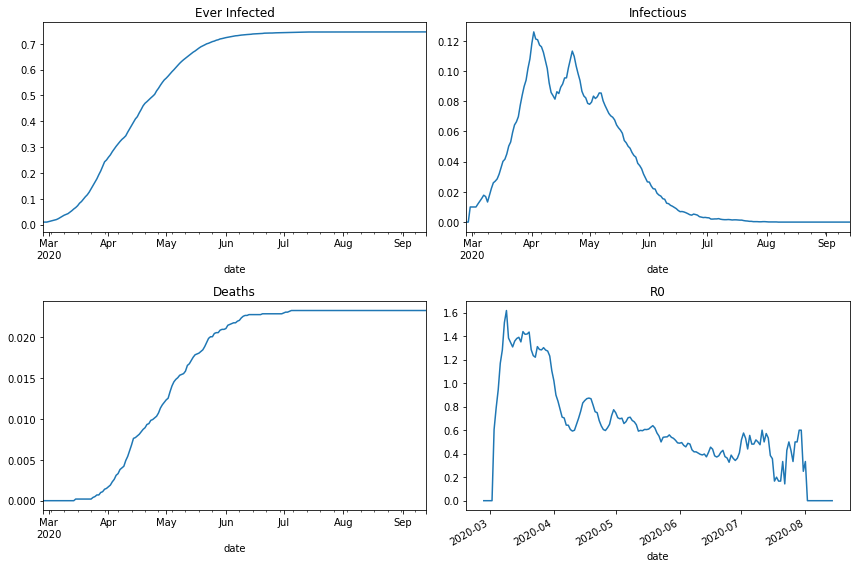

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs = axs.flatten()

df.groupby("date").ever_infected.mean().plot(ax=axs[0])
df.groupby("date").infectious.mean().plot(ax=axs[1])
df.groupby("date").dead.mean().plot(ax=axs[2])

infectious_last_seven_days = df.cd_infectious_false.between(-7, 0)
df.loc[infectious_last_seven_days].groupby("date").infection_counter.mean().plot(ax=axs[3])

axs[0].set_title("Ever Infected")
axs[1].set_title("Infectious")
axs[2].set_title("Deaths")
axs[3].set_title("R0")

fig.tight_layout()